In [1]:
# 크롤링에 필요한 라이브러리
import requests
from bs4 import BeautifulSoup

# 최신 기사 번호를 추출하기 위한 정규표현식
import re

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 형태소 분석
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# csv 저장을 위한 pandas
import pandas as pd

import time

### 기사 크롤링과 전처리
#### KBS World Radio 사이트에서 최근 n개 기사 제목과 내용 크롤링 후 전처리 
#### https://world.kbs.co.kr/service/news_list.htm?lang=e

- requests와 BeautifulSoup를 이용한 크롤링
- Regular Expression을 이용하여 텍스트 전처리

In [2]:
# 기사 목록 사이트에서 최신 기사 번호를 가져옴
# https://world.kbs.co.kr/service/news_list.htm

# 영어 사이트 기준 크롤링 코드
# 한국어 사이트는 html 구조가 다름
def get_latest_news_link(lang='e'):
    """기사 메인 사이트에서 최신 기사 버전 크롤링하는 함수 (기본 언어 : 영어)"""
    
    url = f'https://world.kbs.co.kr/service/news_list.htm?lang={lang}'
    
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    
    # 최신 기사가 있는 css selector에서 기사 링크를 가져옴
    selector = '#container > div > section.comp_contents_1x > article:nth-child(1) > h2 > a'
    select_res = soup.select(selector)

    # 기사 링크가 있는 href 속성
    # . 으로 시작하기 때문에 그 이후부터 추출
    news_link = select_res[0]['href'][1:]
    
    # 메인 사이트 url이랑 합쳐 최신 기사 링크 반환
    return news_link

In [3]:
def extract_news_num(news_link):
    """정규식을 이용하여 기사 url에서 기사 번호를 추출하는 함수"""
    
    # 숫자를 추출하는 정규식 패턴    
    num_pattern = re.compile('[0-9]+')

    # 기사 url에서 뉴스 기사 추출 -> 리스트로 반환 
    # 예시 url : ~/news_view.htm?lang=e&Seq_Code=177309
    news_num = num_pattern.findall(news_link)
    
    # 177309만 추출, 정수형으로 변환
    return int(news_num[0])

In [4]:
latest_news_link = get_latest_news_link()
latest_news_idx = extract_news_num(latest_news_link)

In [5]:
# news_cnt를 조절하면 그 수 만큼 크롤링 가능
def extract_n_th_news(latest_news_idx, news_cnt=20):
    """기사의 제목과 기사 내용을 추출하는 함수
    
    parameter:
    latest_news_idx : 최신 기사 번호
    news_cnt : 추출할 기사 개수
    """
    news_titles = []
    news_contents = []
    
    # 최신 기사 번호에서 1씩 감소해가며 크롤링
    for i in range(news_cnt):
        news_idx = latest_news_idx - i
        
        url = f'https://world.kbs.co.kr/service/news_view.htm?lang=e&Seq_Code={news_idx}'
        
        res = requests.get(url)
        soup = BeautifulSoup(res.text, 'html.parser')
        
        # 태그와 클래스 이름을 통해 기사 제목과 내용을 찾음
        title = soup.find('div', 
                          {'class' : 'title_area'}).get_text()
        
        content = soup.find('div',
                            {'class' : 'body_txt fr-view'}).get_text()
        
        news_titles.append(title)
        news_contents.append(content)
        
        time.sleep(0.5)
        
    return news_titles, news_contents
        
        

In [6]:
# 크롤링한 기사 제목과 기사 내용
titles, contents = extract_n_th_news(latest_news_idx)

In [7]:
def preprocess_titles_and_contents(titles, contents):
    """정규식을 이용하여 기사 제목과 컨텐츠에서 불필요한 문자를 제거하는 함수"""
    
    # 전체 기사 개수, 각 기사 제목과 본문마다 전처리 진행
    total_news_cnt = len(titles)
    
    # 기사 본문에서 사진 출처를 제거
    title_pattern = re.compile('(?<=\n)[^\n]+(?=\nWritten)')
    
    # 사진 출처 텍스트와 기타 개행문자를 제거하기 위한 정규식
    content_pattern = re.compile(r'\n*\s*Photo.*\n\s*')
    backslash_pattern = re.compile(r'[\r\n\xa0]+')
    
    # 전처리 결과 리스트
    preprocessed_titles = []
    preprocessed_contents = []
    
    for i in range(total_news_cnt):
        # i번째 기사 제목 추출
        title = title_pattern.findall(titles[i])[0]
        
        # i번째 기사 본문 사진 출처 텍스트 제거
        content = content_pattern.sub('', contents[i])
        # 출처를 제거한 텍스트에서 i번째 기사 개행문자 제거
        content = backslash_pattern.sub(' ', content)
        
        preprocessed_titles.append(title)
        preprocessed_contents.append(content)
        
    return preprocessed_titles, preprocessed_contents
        

In [8]:
preprocessed_titles, preprocessed_contents = preprocess_titles_and_contents(titles, contents)

### CSV 저장
#### 저장한 데이터를 판다스 데이터프레임화 후 csv로 저장
- pandas

In [9]:
# 전처리한 데이터를 데이터프레임으로 변환
news_df = pd.DataFrame({
    'title' : preprocessed_titles,
    'content' : preprocessed_contents
})

In [10]:
news_df

,title,content
0,KDI: N. Korea Likely to Expand Trade with Chin...,A researcher at a state-run South Korean think...
1,China Protests Seoul's Summon of its Ambassador,China has raised objection with South Korea's ...
2,Four Missing Crew of Russian Fishing Boat Caug...,Rescue authorities found the dead bodies of fo...
3,Gov't to Purchase Rental Homes Affected by Fra...,The government may buy up to 35-thousand homes...
4,Police Chief Asks Cooperation from China on Sp...,The national police commissioner has sent a le...
5,KOSPI Ends Friday Down 0.73%,The benchmark Korea Composite Stock Price Inde...
6,S. Koreans Set for Evacuation from Sudan by Mi...,The government will dispatch a military transp...
7,"Chinese FM: ""Those Who Play with Fire on Taiwa...",Chinese Foreign Minister Qin Gang says those w...
8,"S. Korea, UK, Japanese Lawmakers to Seek to Pr...","Lawmakers from South Korea, Britain and Japan ..."
9,Terraform Labs CEO Kwon Indicted in Montenegro,Prosecutors in Montenegro have reportedly indi...


In [11]:
# 현재 경로에 csv로 저장
news_df.to_csv('kbs_news_crawl_result.csv', index=False)

### 시각화 : 워드클라우드
#### 전처리한 기사 내용을 토대로 워드클라우드 시각화 진행
- nltk를 이용한 영어 형태소 분석
- wordcloud을 이용한 시각화

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chanw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# stopword(불용어) : 특별한 의미 없이 문법적 의미만 가진 단어 목록
stopword = stopwords.words('english')

In [14]:
# keyerror 방지 위해 defaultdict으로 사용
from collections import defaultdict

# 전체 단어 목록
total_words_counter = defaultdict(int)

# 각 전처리한 기사 내용에 대해 빈도수 계산 수행
for article in preprocessed_contents:
    
    # 기사를 공백 단위로 쪼갬 
    # 각 단어를 소문자화 후 불용어인지 확인, 아니라면 빈도수 추가
    for word in article.split():
        word = word.lower()
        if word not in stopword:
            total_words_counter[word] += 1

In [15]:
total_words_counter

defaultdict(int,
            {'researcher': 1,
             'state-run': 1,
             'south': 31,
             'korean': 12,
             'think': 2,
             'tank': 1,
             'believes': 1,
             'north': 12,
             'korea': 18,
             'ease': 1,
             'pandemic': 2,
             'induced': 1,
             'border': 2,
             'closure': 1,
             'address': 1,
             'shortage': 2,
             'industrial': 3,
             'materials.': 1,
             'kim': 5,
             'soo-jeong': 1,
             'institute': 2,
             'economics': 1,
             'trade': 2,
             'offered': 1,
             'analysis': 1,
             'presentation': 1,
             'academic': 1,
             'forum': 3,
             'friday.': 3,
             'said': 18,
             'intermediate': 1,
             'capital': 7,
             'goods': 1,
             'must': 2,
             'worsened': 1,
             'decreased': 1,
   

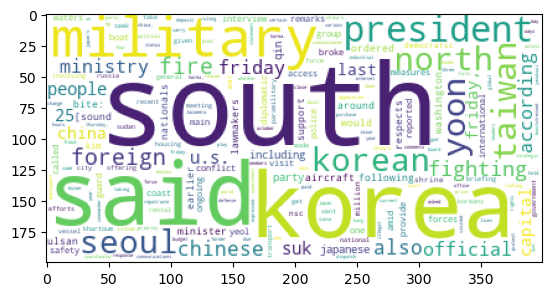

In [30]:
# 빈도수 딕셔너리 토대로 워드클라우드 시각화
wordcloud = WordCloud(
    background_color='white'
)

wordcloud.generate_from_frequencies(total_words_counter)

plt.imshow(wordcloud)